In [387]:
import numpy as np
import scipy.misc # to visualize only
import os
from PIL import Image
import pickle
import h5py
import cv2
import matplotlib.pyplot as plt
import imutils
import time
import copy
from google.colab.patches import cv2_imshow

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/Comp551_P3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [388]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

(56000, 64, 64, 1)
(56000, 5)
(14000, 64, 64, 1)


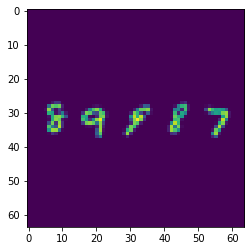

In [389]:
# Load dataset
f = h5py.File(path+'MNIST_synthetic.h5','r')
x_train = np.array(f.get('train_dataset'))
y_train = np.array(f.get('train_labels'))
x_test = np.array(f.get('test_dataset'))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

img1 = Image.fromarray(np.uint8(x_train[1][:,:,0]))
# img2 = x_train[1][:,:,0]
# cv2_imshow(img2)
plt.imshow(img1)

In [390]:
def isolate_digits (img):
  x_space_coord = []
  y_space_coord = []

  sum_thresh = 0    # If sum of all pixels is above this threshold, then we found a digit
  on_digit = False

  req_num_counts = 2       # We need to detect a digit at least this many number of times to consider it a digit
  digit_count = 0
  empty_count = 0

  # Slide a vertical rectangle to detect empty spaces between digits
  rect_width = 2
  for x in range(img.shape[1] - rect_width):

    rect_window = img[:,x:x+rect_width]
    s = np.sum(rect_window)

    # We may have found a digit
    if s > sum_thresh:
      digit_count += 1
      empty_count = 0
      if  digit_count >= req_num_counts and on_digit == False:
        on_digit = True
        x_space_coord.append(x - 5) if len(x_space_coord) % 2 == 0 else x_space_coord.append(x + 5 - rect_width)

    # We may have found a space between digits
    else:
      empty_count += 1
      digit_count = 0
      if  empty_count >= req_num_counts and on_digit == True:
        on_digit = False
        x_space_coord.append(x - 5) if len(x_space_coord) % 2 == 0 else x_space_coord.append(x + 5 - rect_width)

  y1 = 100
  # y1 = 125
  y2 = 200
  # y2 = 175

  # The segmented images won't have the same shape, we can resize them later
  digit_imgs = []

  for i, x1 in enumerate(x_space_coord[::2]):
    x2 = x_space_coord[2 * i + 1]
    digit_imgs.append(cv2.resize(img[y1:y2, x1:x2], (50, 100)))

  # # Plot segmented digits
  # for i, d_img in enumerate(digit_imgs):
  #   plt.subplot(1, len(digit_imgs), i+1), plt.imshow(cv2.resize(d_img, (50, 100)))
  # plt.show()

  return digit_imgs

In [391]:
def preprocess_img_data(data, labels=[], train=True):

  temp_data = copy.deepcopy(data)
  temp_labels = copy.deepcopy(labels)

  segmented_img_list = []
  t0 = time.time()
  count = 0
  for i, img in enumerate(temp_data):

    if i % (temp_data.shape[0] / 10) == 0:
    # print(i)
      print("{}% done in {}s".format(int(i / temp_data.shape[0] * 100), time.time()-t0))

    # Get image array and resize
    img = Image.fromarray(np.uint8(img[:,:,0]))
    newsize = (300, 300) 
    im1 = img.resize(newsize)
    cimg = cv2.cvtColor(np.array(im1), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian filter to image
    # blurred = cv2.GaussianBlur(gray, (5,5), 0) 
    # plt.imshow(blurred)

    # Find edges using the Canny Edge detector
    # edged = cv2.Canny(blurred, 50, 200, 255)
    # plt.imshow(edged)

    # Find the digit countours
    # cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # cnts = imutils.grab_contours(cnts)
    # cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # displayCnt = None
    # print(cnts)

    # Fill the countours
    # thresh = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
    # thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    # plt.imshow(thresh)

    # Isolate single digits in the image
    isolated_digits = isolate_digits(gray)

    # For training we do not need to keep track of which digits are in which image
    # we only need to know the correspondence between a digit and its label
    if train:
      # segmented_img_list += isolated_digits
      # If number of digits found does not match the number of labels, then we don't train on this image
      if len(isolated_digits) == len(temp_labels[count]):
        segmented_img_list += isolated_digits
        count += 1
      else:
        del temp_labels[count]
    else:
      segmented_img_list.append(isolated_digits)

  return np.array(segmented_img_list), temp_labels


In [392]:
# Preprocess the images in x_train and x_test and the labels in y_train and run for num_points from training set
num_points = 56000

# Remove class '10' from training labels
y_train_without_10 = []
for temp1 in y_train[:num_points,:]:
# for temp1 in y_train:
  y_train_without_10.append(np.delete(temp1, np.where(temp1 == 10)))
print("length y_train: ", len(y_train_without_10))

print("Segmenting training data: ")
x_train_segmented, y_train_processed = preprocess_img_data(x_train[:num_points], y_train_without_10, train=True)
print("Segmenting test data: ")
x_test_segmented,_ = preprocess_img_data(x_test, train=False)

# Flatten the training labels (can't use np.flatten because array contains subarrays of different dimensions)
y_train_segmented = np.array([])
for temp2 in y_train_processed:
  # print(temp2)
  y_train_segmented = np.concatenate((y_train_segmented, temp2))

# print(x_train_segmented)
# The number of elements in x_train (#digits) should match the number of elements in y_train (#labels)
print("xtrain: ", x_train_segmented.shape)
print("ytrain: ", y_train_segmented.shape)
print("xtest: ", x_test_segmented.shape)

# Flatten images to 1D vector
num_pixels = x_train_segmented.shape[1] * x_train_segmented.shape[2]
x_train_segmented = x_train_segmented.reshape((x_train_segmented.shape[0], num_pixels)).astype('float32')

# normalize inputs from 0-255 to 0-1
x_train_segmented = x_train_segmented / 255

# one hot encode outputs
y_train_segmented = np_utils.to_categorical(y_train_segmented)
num_classes = y_train_segmented.shape[1]
print("num_classes_train", num_classes)


length y_train:  56000
Segmenting training data: 
0% done in 3.1948089599609375e-05s
10% done in 21.997665882110596s
20% done in 44.235491037368774s
30% done in 66.70092940330505s
40% done in 91.33673548698425s
50% done in 113.44516944885254s
60% done in 135.61089062690735s
70% done in 157.88945889472961s
80% done in 180.56691718101501s
90% done in 203.22192883491516s
Segmenting test data: 
0% done in 2.384185791015625e-05s
10% done in 5.558237075805664s
20% done in 11.064635038375854s
30% done in 16.58302927017212s
40% done in 22.075692415237427s
50% done in 27.53716778755188s
60% done in 33.00840473175049s
70% done in 38.54442596435547s
80% done in 44.1126024723053s
90% done in 49.67366361618042s
xtrain:  (165466, 100, 50)
ytrain:  (165466,)
xtest:  (14000,)
num_classes_train 10


In [393]:
# Define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [394]:
# Build the model
print("xtrain: ", x_train_segmented.shape)
print("ytrain: ", y_train_segmented.shape)
print("xtest: ", x_test_segmented.shape)
model = baseline_model()
# Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
model.fit(x_train_segmented, y_train_segmented, epochs=10, batch_size=200, verbose=2)

xtrain:  (165466, 5000)
ytrain:  (165466, 10)
xtest:  (14000,)
Epoch 1/10
828/828 - 367s - loss: 0.2820 - accuracy: 0.9493
Epoch 2/10
828/828 - 364s - loss: 0.0588 - accuracy: 0.9812
Epoch 3/10
828/828 - 361s - loss: 0.0425 - accuracy: 0.9864
Epoch 4/10
828/828 - 338s - loss: 0.0334 - accuracy: 0.9890
Epoch 5/10
828/828 - 348s - loss: 0.0298 - accuracy: 0.9904
Epoch 6/10
828/828 - 349s - loss: 0.0242 - accuracy: 0.9920
Epoch 7/10
828/828 - 356s - loss: 0.0225 - accuracy: 0.9927
Epoch 8/10
828/828 - 366s - loss: 0.0175 - accuracy: 0.9943
Epoch 9/10
828/828 - 364s - loss: 0.0151 - accuracy: 0.9949
Epoch 10/10
828/828 - 368s - loss: 0.0148 - accuracy: 0.9951


sample_shape:  (4, 100, 50)
prediction_probabilities:  [[4.0808829e-04 9.9539870e-01 8.6775835e-05 5.5307831e-04 3.1022781e-05
  1.5905119e-06 2.7334841e-06 1.2904851e-04 2.7622657e-03 6.2663946e-04]
 [9.9998903e-01 5.8052378e-12 6.1055125e-06 6.5500933e-07 6.2034964e-09
  1.7262644e-06 1.1827065e-07 2.0806742e-10 1.4939573e-08 2.3630839e-06]
 [6.1194537e-17 1.6091751e-18 2.1207848e-13 1.3482922e-07 1.4346009e-09
  8.9310653e-10 3.7751390e-16 9.6029532e-13 1.5976049e-08 9.9999988e-01]
 [1.4559096e-20 2.4095804e-21 9.9543949e-18 1.0000000e+00 3.8096546e-25
  9.7705044e-10 7.4068477e-27 3.5653989e-20 7.1290778e-19 2.9951876e-17]]
highest_label_probabilities:  [1 0 9 3]
sample_output:  [ 1  0  9  3 10]
Image: 


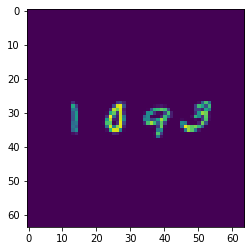

In [396]:
# Sample prediction
index = 12
y_sample = np.array([10,10,10,10,10])

sample = np.array(x_test_segmented[index])
print("sample_shape: ", sample.shape)
# print("sample", sample)

# Flatten images to 1D vector
num_pixels = sample.shape[1] * sample.shape[2]
sample = sample.reshape((sample.shape[0], num_pixels)).astype('float32')
sample = sample / 255     # normalize inputs from 0-255 to 0-1

y_pred = model.predict(sample)
print("prediction_probabilities: ", y_pred)
y_pred = np.argmax(y_pred, axis=1)   # Find label with highest probability
print("highest_label_probabilities: ", y_pred)

# Replace y_sample (full of '10' with predictions)
num_labels = y_pred.shape[0]
y_sample[0:num_labels] = y_pred
print("sample_output: ", y_sample)

print("Image: ")
img = Image.fromarray(np.uint8(x_test[index][:,:,0]))
plt.imshow(img)


In [397]:
# Predict over the whole test set
y_test_pred_arr = []
t0 = time.time()

for i, test_point in enumerate(x_test_segmented):

  # print(i)
  if i % (x_test_segmented.shape[0] / 20) == 0:
      print("{}% done in {}s".format(int(i / x_test_segmented.shape[0] * 100), time.time()-t0))

  test_point = np.array(test_point)
  y_temp = np.array([10,10,10,10,10])
  # Flatten images to 1D vector
  num_pixels = test_point.shape[1] * test_point.shape[2]
  test_point = test_point.reshape((test_point.shape[0], num_pixels)).astype('float32')
  test_point = test_point / 255     # normalize inputs from 0-255 to 0-1

  y_pred = model.predict(test_point)
  y_pred = np.argmax(y_pred, axis=1)   # Find label with highest probability

  # Sanity check (no more than 5 digits)
  if y_pred.shape[0] > 5:
    y_pred = y_pred[0:5]

  # Replace y_temp (full of '10' with predictions)
  num_labels = y_pred.shape[0]
  y_temp[0:num_labels] = y_pred

  y_test_pred_arr.append(y_temp)

y_test_pred_arr = np.array(y_test_pred_arr)
print(y_test_pred_arr.shape)


0% done in 0.00035262107849121094s
5% done in 49.24916195869446s
10% done in 98.66523432731628s
15% done in 148.21721076965332s
20% done in 196.46611499786377s
25% done in 245.55666279792786s
30% done in 295.00150871276855s
35% done in 344.08367800712585s
40% done in 389.5834286212921s
45% done in 434.3766167163849s
50% done in 483.3437798023224s
55% done in 532.8931088447571s
60% done in 581.0541481971741s
65% done in 628.8318133354187s
70% done in 675.6689264774323s
75% done in 721.7815475463867s
80% done in 767.9375808238983s
85% done in 814.7199757099152s
90% done in 860.8541193008423s
95% done in 906.399453163147s
(14000, 5)


In [398]:
# Format output as specified on the instructions
import csv

# y_test_pred_arr
# Turn arrays of integer labels into strings
output = []
for y_labels in y_test_pred_arr:
  string_ints = [str(d) for d in y_labels]
  output.append("".join(string_ints))

output = np.array(output)
# print(y_test_pred_arr.shape)
# print(output.shape)

# Add index to each output label string
output = np.column_stack((np.arange(y_test_pred_arr.shape[0]), output))
# print(output)
# print(output.shape)

# Add  Id, Label header
output = np.concatenate(([['Id', 'Label']], output))
print(output)
print(output.shape)

np.savetxt(path+"submission2.csv", output, delimiter=",", fmt='%s')


[['Id' 'Label']
 ['0' '910101010']
 ['1' '017310']
 ...
 ['13997' '310101010']
 ['13998' '419710']
 ['13999' '58309']]
(14001, 2)
